In [5]:
# Data imports
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# # ML imports
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.models import Sequential, load_model
# from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences

In [6]:
# read data
df = pd.read_csv("models/tweets.csv")

# clean data
df = df.sample(frac=1).reset_index(drop=True)
df = df[["airline_sentiment", "text"]]

# clean tweet text
df['text'] = df['text'].apply(lambda x: x.lower()) #transform text to lowercase
df['text'] = df['text'].apply(lambda x: re.sub('[^a-zA-z0-9\s]', '', x))

print(df.shape)
df.head(10)

(14640, 2)


,airline_sentiment,text
0,negative,usairways cant get back lost time
1,negative,usairways three hours on hold then disconnecte...
2,positive,united for the record rozana at newark was lov...
3,negative,southwestair never got any notification that f...
4,negative,usairways your service has been awful in bosto...
5,neutral,virginamerica are flights leaving dallas for s...
6,negative,united well now finally on board hopefully we...
7,negative,usairways and then you said i could move my th...
8,negative,united ok thank you do you provide complimenta...
9,neutral,you know what rt jetblue our fleets on fleek ...


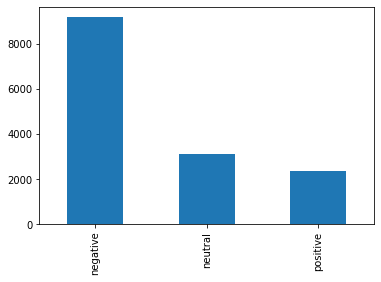

In [10]:
df['airline_sentiment'].value_counts().sort_index().plot.bar()
plt.savefig("images/single_count.png")

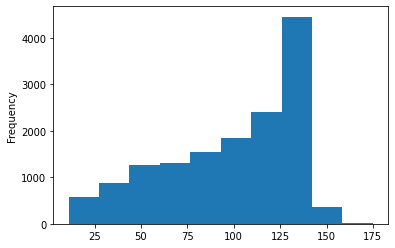

In [12]:
df['text'].str.len().plot.hist()
plt.savefig("images/tweet_len.png")

In [18]:
# tokenize 
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['text'].values)

X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X)
print(X[:5])

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0   78  216  297   15
    44    2  910 1257 1429]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0   13  165  170  197   18   11  553  119   60   28  795    9
  3670 3098 1371 1512  928]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0   16    3  289  391   51   90   60   56   10   23   24  296    1
    30    2    8    3  624]
 [   0    0    0    0    0    0    0    0    0    0    0    5   36    7
     2  275   50   42   10  122   91  134   20  132  796   19 3671    7
    11  863 1916  838  312]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0   13  183   43    3  864  309  178    1   58
   178  367 1204  190 1205]]


In [19]:
# create model
model = Sequential()
model.add(Embedding(5000, 256, input_length=X.shape[1]))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model.add(LSTM(256, dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

In [20]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 33, 256)           1280000   
_________________________________________________________________
dropout (Dropout)            (None, 33, 256)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 33, 256)           525312    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense (Dense)                (None, 3)                 771       
Total params: 2,331,395
Trainable params: 2,331,395
Non-trainable params: 0
_________________________________________________________________


In [24]:
y = pd.get_dummies(df['airline_sentiment']).values
[print(df['airline_sentiment'][i], y[i]) for i in range(0,5)]

negative [1 0 0]
negative [1 0 0]
negative [1 0 0]
negative [1 0 0]
negative [1 0 0]


[None, None, None, None, None]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [26]:
batch_size = 32
epochs = 8

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)

Epoch 1/8
366/366 - 190s - loss: 0.6508 - accuracy: 0.7309
Epoch 2/8
366/366 - 190s - loss: 0.4424 - accuracy: 0.8297
Epoch 3/8
366/366 - 199s - loss: 0.3576 - accuracy: 0.8663
Epoch 4/8
366/366 - 203s - loss: 0.2908 - accuracy: 0.8931
Epoch 5/8
366/366 - 199s - loss: 0.2374 - accuracy: 0.9122
Epoch 6/8
366/366 - 199s - loss: 0.1960 - accuracy: 0.9248
Epoch 7/8
366/366 - 200s - loss: 0.1645 - accuracy: 0.9378
Epoch 8/8
366/366 - 203s - loss: 0.1393 - accuracy: 0.9483


In [27]:
model.save("sentiment_model.h5")

In [30]:
predictions = model.predict(X_test)
avg_neg = np.mean([prediction[0] for prediction in predictions])
avg_neu = np.mean([prediction[1] for prediction in predictions])
avg_pos = np.mean([prediction[2] for prediction in predictions])
print(avg_neg, avg_neu, avg_pos)

0.6559028 0.19519587 0.14890131


In [31]:
pos_count, neu_count, neg_count = 0, 0, 0
real_pos, real_neu, real_neg = 0, 0, 0
for i, prediction in enumerate(predictions):
    if np.argmax(prediction)==2:
        pos_count += 1
    elif np.argmax(prediction)==1:
        neu_count += 1
    else:
        neg_count += 1
    
    if np.argmax(y_test[i])==2:
        real_pos += 1
    elif np.argmax(y_test[i])==1:    
        real_neu += 1
    else:
        real_neg +=1

print('Positive predictions:', pos_count)
print('Neutral predictions:', neu_count)
print('Negative predictions:', neg_count)
print('Real positive:', real_pos)
print('Real neutral:', real_neu)
print('Real negative:', real_neg)

Positive predictions: 446
Neutral predictions: 535
Negative predictions: 1947
Real positive: 470
Real neutral: 622
Real negative: 1836


In [37]:
import matplotlib.pyplot as plt

In [38]:
la_per_epoch = [
{"epoch": 1, "loss": 0.6508, "accuracy": 0.7309},
{"epoch": 2, "loss": 0.4424, "accuracy": 0.8297},
{"epoch": 3, "loss": 0.3576, "accuracy": 0.8663},
{"epoch": 4, "loss": 0.2908, "accuracy": 0.8931},
{"epoch": 5, "loss": 0.2374, "accuracy": 0.9122},
{"epoch": 6, "loss": 0.1960, "accuracy": 0.9248},
{"epoch": 7, "loss": 0.1645, "accuracy": 0.9378},
{"epoch": 8, "loss": 0.1393, "accuracy": 0.9483}
]
predictions = [pos_count, neu_count, neg_count]
real = [real_pos, real_neu, real_neg]
labels = ['Positive', 'Neutral', 'Negative']

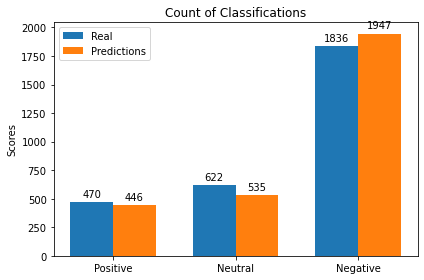

In [41]:
x = np.arange(len(labels))
width = 0.35 

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, real, width, label='Real')
rects2 = ax.bar(x + width/2, predictions, width, label='Predictions')

ax.set_ylabel('Scores')
ax.set_title('Count of Classifications')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()
plt.savefig("images/count.png")
plt.show()

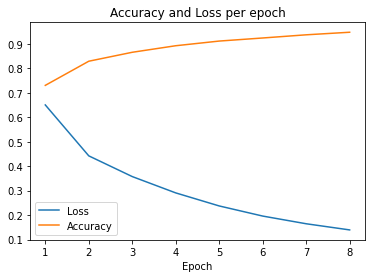

In [42]:
fig, ax = plt.subplots()
loss = [item['loss'] for item in la_per_epoch]
epoch = [item['epoch'] for item in la_per_epoch]
accuracy = [item['accuracy'] for item in la_per_epoch]
ax.plot(epoch, loss, label = "Loss")
ax.plot(epoch, accuracy, label = "Accuracy")

ax.set_xlabel('Epoch')
ax.set_title('Accuracy and Loss per epoch')
plt.legend()
plt.savefig("images/epoch.png")
plt.show()